In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv

import IPython.display as display
from PIL import Image

from sklearn.model_selection import train_test_split


In [55]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

2.5.0


In [56]:
colon_main = pd.read_csv("./Image_classification_data/data_labels_mainData.csv")

In [57]:
colon_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [58]:
colon_main.drop(['cellTypeName'], axis=1, inplace=True)

In [59]:
colon_main.dtypes

InstanceID      int64
patientID       int64
ImageName      object
cellType        int64
isCancerous     int64
dtype: object

In [60]:
colon_main.isnull().sum()

InstanceID     0
patientID      0
ImageName      0
cellType       0
isCancerous    0
dtype: int64

In [61]:
train_data, test_data = train_test_split(colon_main, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, \nVal Data: {}, \nTest Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, 
Val Data: 1979, 
Test Data: 1980


In [62]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [63]:
#import os, shutil, glob

#src_dir = "./Image_classification_data/patch_images"
#dst_dir = "./Image_classification_data/main_images"

#for img in colon_main['ImageName']:
#    shutil.copy(os.path.join(src_dir, img), dst_dir)
    

# Approach for the task 3
### 1. Initializing the extra data
### 2. Split the data into 3 equal halves
### 3. Predict the cellType for the 1st batch of data using the previously saved model
### 4. Replace the cellType 1st batch of data
### 5. Load the base neural netwwork model
### 6. Train the base model with the concept of transfer learning
### 7. Repeat Steps 3 - 6 for the other 2 batches of data

In [64]:
colon_extra = pd.read_csv("./Image_classification_data/data_labels_extraData.csv")

In [65]:
#import os, shutil, glob

#src_dir = "./Image_classification_data/patch_images"
#dst_dir = "./Image_classification_data/extra_images"

#for img in colon_extra['ImageName']:
    
#    shutil.copy(os.path.join(src_dir, img), dst_dir)
    

In [66]:
train_data, train_data_1 = train_test_split(colon_extra, test_size=colon_extra.shape[0]//3, random_state=42)
train_data, train_data_2 = train_test_split(train_data, test_size=colon_extra.shape[0]//3, random_state=42)

print("Batch 1 : {}, \nBatch 2: {}, \nBatch 3: {}".format(train_data.shape[0], train_data_1.shape[0], train_data_2.shape[0]))

Batch 1 : 3462, 
Batch 2: 3461, 
Batch 3: 3461


In [67]:
train_data.head()

,InstanceID,patientID,ImageName,isCancerous
6837,9612,86,9612.png,0
7097,12301,87,12301.png,0
9420,21326,92,21326.png,0
9074,19498,91,19498.png,0
5483,17855,82,17855.png,0


## Batch - 1 Training

In [68]:
base_model = load_model("predict_celltype.h5")

In [69]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

X, train_data['cellType'], = make_blobs(n_samples=3462, centers=4, n_features=1, random_state=42)


In [70]:
np.unique(train_data['cellType'])

array([0, 1, 2, 3])

In [71]:
train_data.shape

(3462, 5)

In [72]:
train_data['cellType'] = train_data['cellType'].astype('str')

cell_train_datagen = ImageDataGenerator(
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 1

cell_train_generator = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/extra_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 3462 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [73]:
base_model.evaluate(cell_train_generator)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


3462/3462 [==============================] - 9s 2ms/step - loss: 3.4509 - categorical_accuracy: 0.2571


[3.4509260654449463, 0.25707682967185974]

In [74]:
preds = []
filenames = cell_train_generator.filenames
N_images = len(filenames)
batches = 0

for i in range(0, 3462):
    preds.append(np.argmax(base_model.predict(cell_train_generator[i][0])))
    batches += 1
    if batches >= N_images / 1:
        break

In [75]:
train_data.drop(['cellType'], axis=1, inplace=True)
train_data['cellType'] = preds

In [76]:
train_data.shape

(3462, 5)

In [77]:
train_batch_1 = pd.concat([colon_main, train_data])
train_batch_1.shape

(13358, 5)

In [78]:
train_data, test_data = train_test_split(train_batch_1, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, \nVal Data: {}, \nTest Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 8014, 
Val Data: 2672, 
Test Data: 2672


In [79]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

cell_train_datagen = ImageDataGenerator(rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)
cell_val_datagen = ImageDataGenerator(rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 27

cell_train_generator_1 = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator_1 = cell_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 8014 validated image filenames belonging to 4 classes.
Found 2672 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [80]:
reg_lambda = 0.001
base_model.trainable = False
# add new classifier layers

inputs = tf.keras.Input(shape=(27, 27, 3))
x = base_model(inputs, training=False)
class1 = Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(class1)
model = tf.keras.Model(inputs, outputs)

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 27, 27, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 4)                 107160    
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              5120      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 4100      
Total params: 116,380
Trainable params: 9,220
Non-trainable params: 107,160
_________________________________________________________________


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator s

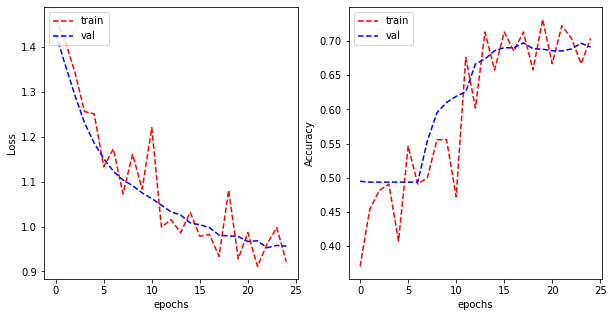

In [81]:
cell_history = model.fit_generator(cell_train_generator_1, validation_data = cell_validation_generator_1, epochs=25, steps_per_epoch=4, verbose=0)

plot_learning_curve(cell_history.history['loss'], cell_history.history['val_loss'], 
                    cell_history.history['categorical_accuracy'], cell_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [82]:
test_data['cellType'] = test_data['cellType'].astype('str')

cell_test_datagen = ImageDataGenerator(                               
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 1

cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

model.evaluate(cell_test_generator)

Found 2672 validated image filenames belonging to 4 classes.
  42/2672 [..............................] - ETA: 6s - loss: 1.0370 - categorical_accuracy: 0.5952    

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('Thi

2672/2672 [==============================] - 7s 2ms/step - loss: 0.9538 - categorical_accuracy: 0.6879


[0.9537730813026428, 0.6878742575645447]

# Batch - 1 Fine Tuning

In [83]:
reg_lambda = 0.001
base_model.trainable = True
# add new classifier layers

inputs = tf.keras.Input(shape=(27, 27, 3))
x = base_model(inputs, training=True)
class1 = Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(class1)
final_model = tf.keras.Model(inputs, outputs)

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
final_model.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

final_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 27, 27, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 4)                 107160    
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              5120      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 4100      
Total params: 116,380
Trainable params: 116,380
Non-trainable params: 0
_________________________________________________________________


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


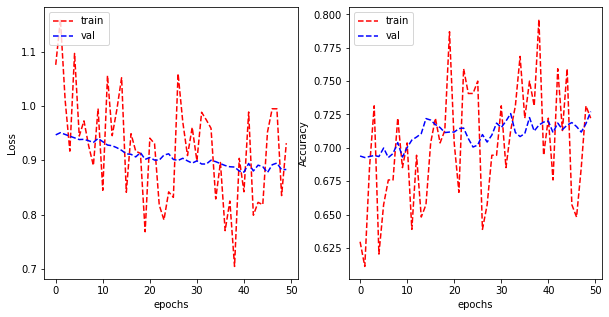

In [84]:
cell_history_train = model.fit_generator(cell_train_generator_1, validation_data = cell_validation_generator_1, epochs=50, steps_per_epoch=4, verbose=0)

plot_learning_curve(cell_history_train.history['loss'], cell_history_train.history['val_loss'], 
                    cell_history_train.history['categorical_accuracy'], cell_history_train.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [85]:
test_data['cellType'] = test_data['cellType'].astype('str')

cell_test_datagen = ImageDataGenerator(                               
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 1

cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

final_model.evaluate(cell_test_generator)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('Thi

Found 2672 validated image filenames belonging to 4 classes.
2672/2672 [==============================] - 7s 2ms/step - loss: 1.4798 - categorical_accuracy: 0.1718


[1.479791283607483, 0.17178143560886383]

In [86]:
model.save("batch_1_model.h5")

## Batch 2 - Training

In [87]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

X, train_data_1['cellType'], = make_blobs(n_samples=3461, centers=4, n_features=1, random_state=42)
train_data_1.head()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,InstanceID,patientID,ImageName,isCancerous,cellType
8952,19370,91,19370.png,0,3
2922,1816,77,1816.png,0,2
1803,6543,68,6543.png,1,3
8102,14850,89,14850.png,0,0
3438,2373,77,2373.png,0,2


In [88]:
train_data_1['cellType'] = train_data_1['cellType'].astype('str')

cell_train_datagen = ImageDataGenerator(
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 1

cell_train_generator = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data_1,
        directory='./Image_classification_data/extra_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 3461 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('Thi

In [89]:
batch_1_base = load_model("batch_1_model.h5")
batch_1_base.evaluate(cell_train_generator)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


3461/3461 [==============================] - 8s 2ms/step - loss: 2.1863 - categorical_accuracy: 0.2467


[2.186264753341675, 0.24674949049949646]

In [90]:
preds = []
filenames = cell_train_generator.filenames
N_images = len(filenames)
batches = 0

for i in range(0, 3462):
    preds.append(np.argmax(base_model.predict(cell_train_generator[i][0])))
    batches += 1
    if batches >= N_images / 1:
        break
train_data_1.drop(['cellType'], axis=1, inplace=True)
train_data_1['cellType'] = preds
train_batch_2 = pd.concat([train_batch_1, train_data_1])
train_batch_2.shape

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(16819, 5)

In [91]:
train_data, test_data = train_test_split(train_batch_2, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, \nVal Data: {}, \nTest Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 10091, 
Val Data: 3364, 
Test Data: 3364


In [92]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

cell_train_datagen = ImageDataGenerator(rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)
cell_val_datagen = ImageDataGenerator(rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 27

cell_train_generator_2 = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator_2 = cell_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 10091 validated image filenames belonging to 4 classes.
Found 3364 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [93]:
reg_lambda = 0.001
batch_1_base.trainable = False
# add new classifier layers

inputs = tf.keras.Input(shape=(27, 27, 3))
x = batch_1_base(inputs, training=False)
class1 = Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(class1)
batch_2_model = tf.keras.Model(inputs, outputs)

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
batch_2_model.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

batch_2_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 27, 27, 3)]       0         
_________________________________________________________________
model_3 (Functional)         (None, 4)                 116380    
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              5120      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 4100      
Total params: 125,600
Trainable params: 9,220
Non-trainable params: 116,380
_________________________________________________________________


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator s

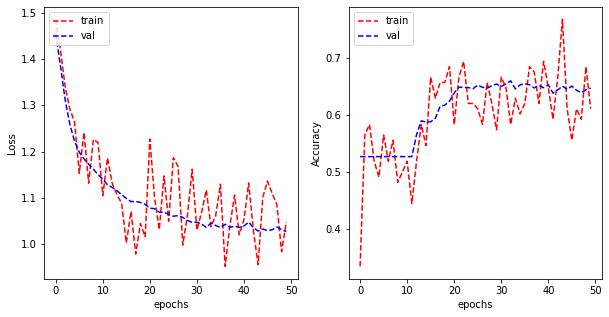

In [94]:
cell_history = batch_2_model.fit_generator(cell_train_generator_2, validation_data = cell_validation_generator_2, epochs=50, steps_per_epoch=4, verbose=0)

plot_learning_curve(cell_history.history['loss'], cell_history.history['val_loss'], 
                    cell_history.history['categorical_accuracy'], cell_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [95]:
test_data['cellType'] = test_data['cellType'].astype('str')

cell_test_datagen = ImageDataGenerator(                               
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 1

cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

batch_2_model.evaluate(cell_test_generator)

Found 3364 validated image filenames belonging to 4 classes.
  21/3364 [..............................] - ETA: 8s - loss: 1.1430 - categorical_accuracy: 0.5714      

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('Thi

3364/3364 [==============================] - 9s 3ms/step - loss: 1.0308 - categorical_accuracy: 0.6489


[1.0308477878570557, 0.6489298343658447]

In [96]:
batch_2_model.save("batch_2_model.h5")

## Batch - 3 Training

In [97]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

X, train_data_2['cellType'], = make_blobs(n_samples=3461, centers=4, n_features=1, random_state=42)
train_data_2.head()

,InstanceID,patientID,ImageName,isCancerous,cellType
2317,10423,70,10423.png,1,3
9587,21511,92,21511.png,0,2
7861,14584,89,14584.png,0,3
2237,10335,70,10335.png,0,0
5412,15417,81,15417.png,0,2


In [98]:
train_data_2['cellType'] = train_data_2['cellType'].astype('str')

cell_train_datagen = ImageDataGenerator(
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 1

cell_train_generator = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data_2,
        directory='./Image_classification_data/extra_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 3461 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [99]:
batch_2_base = load_model("batch_2_model.h5")
batch_2_base.evaluate(cell_train_generator)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


3461/3461 [==============================] - 9s 3ms/step - loss: 1.9871 - categorical_accuracy: 0.2557


[1.9871114492416382, 0.25570642948150635]

In [100]:
preds = []
filenames = cell_train_generator.filenames
N_images = len(filenames)
batches = 0

for i in range(0, 3462):
    preds.append(np.argmax(base_model.predict(cell_train_generator[i][0])))
    batches += 1
    if batches >= N_images / 1:
        break
train_data_2.drop(['cellType'], axis=1, inplace=True)
train_data_2['cellType'] = preds
train_batch_3 = pd.concat([train_batch_2, train_data_2])
train_batch_3.shape

(20280, 5)

In [101]:
train_data, test_data = train_test_split(train_batch_3, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, \nVal Data: {}, \nTest Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, 
Val Data: 4056, 
Test Data: 4056


In [102]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

cell_train_datagen = ImageDataGenerator(rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)
cell_val_datagen = ImageDataGenerator(rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 27

cell_train_generator_3 = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator_3 = cell_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 4 classes.
Found 4056 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [103]:
reg_lambda = 0.001
batch_2_base.trainable = False
# add new classifier layers

inputs = tf.keras.Input(shape=(27, 27, 3))
x = batch_2_base(inputs, training=False)
class1 = Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(class1)
batch_3_model = tf.keras.Model(inputs, outputs)

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
batch_3_model.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

batch_3_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 27, 27, 3)]       0         
_________________________________________________________________
model_5 (Functional)         (None, 4)                 125600    
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              5120      
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 4100      
Total params: 134,820
Trainable params: 9,220
Non-trainable params: 125,600
_________________________________________________________________


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator s

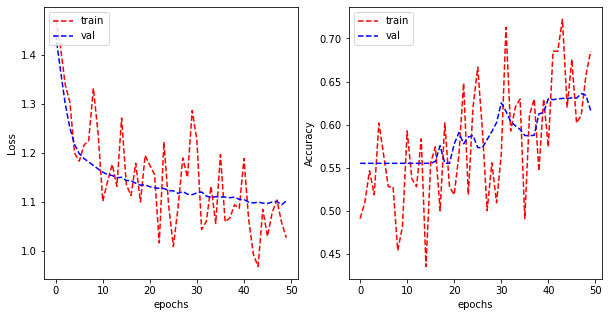

In [104]:
cell_history = batch_3_model.fit_generator(cell_train_generator_3, validation_data = cell_validation_generator_3, epochs=50, steps_per_epoch=4, verbose=0)

plot_learning_curve(cell_history.history['loss'], cell_history.history['val_loss'], 
                    cell_history.history['categorical_accuracy'], cell_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [105]:
test_data['cellType'] = test_data['cellType'].astype('str')

cell_test_datagen = ImageDataGenerator(                               
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 1

cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

batch_3_model.evaluate(cell_test_generator)

Found 4056 validated image filenames belonging to 4 classes.
  20/4056 [..............................] - ETA: 10s - loss: 1.2210 - categorical_accuracy: 0.6000 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('Thi

4056/4056 [==============================] - 10s 2ms/step - loss: 1.0752 - categorical_accuracy: 0.6432


[1.0752428770065308, 0.6432445645332336]

In [106]:
batch_3_model.save("batch_3_model.h5")

## Tesing the final model

In [107]:
label_names = {'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


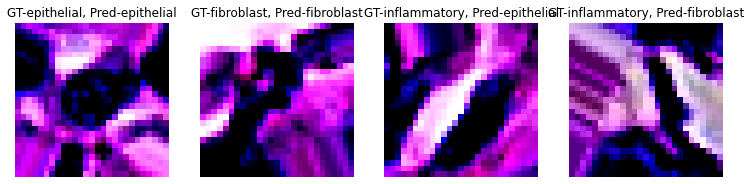

In [108]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in cell_train_generator:
        batches = batches + 1
        y_hat = batch_3_model.predict(x, verbose=0)
        
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])]))
        else:
            break
        
        plt.axis('off')

# Clustering unlabelled data by extracting features from the saved model

In [122]:
cell_type_model_reg_pred = load_model("predict_celltype.h5")
model = Model(cell_type_model_reg_pred.input, cell_type_model_reg_pred.output)

In [123]:
reg_lambda = 0.001
model.trainable = False
# add new classifier layers

inputs = tf.keras.Input(shape=(27, 27, 3))
x = model(inputs, training=False)
class1 = Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))(class1)
cluster_model = tf.keras.Model(inputs, outputs)

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
cluster_model.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

cluster_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 27, 27, 3)]       0         
_________________________________________________________________
model_9 (Functional)         (None, 4)                 107160    
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              5120      
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 4100      
Total params: 116,380
Trainable params: 9,220
Non-trainable params: 107,160
_________________________________________________________________


In [124]:
FlattenImages = {
    'photo_name' : [],
    'flattenPhoto' : [],
    }

In [125]:
colon_extra['FlattenData'] = None
for img in colon_extra['ImageName']:
    FlattenImages['photo_name'].append(img)
    path = './Image_classification_data/patch_images/' + img
    img = cv.imread(path)
    img = cv.resize(img, (27, 27))
    ## Expanding image dims so this represents 1 sample
    img = img = np.expand_dims(img, 0)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    extractedFeatures = cluster_model.predict(img)
    extractedFeatures = np.array(extractedFeatures)
    FlattenImages['flattenPhoto'].append(extractedFeatures.flatten())

In [126]:
Training_Feature_vector = np.array(FlattenImages['flattenPhoto'], dtype = 'float64')
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
kmeans.fit(Training_Feature_vector)

KMeans(max_iter=600, n_clusters=4)

In [115]:
dimReducedDataFrame = pd.DataFrame(Training_Feature_vector)
dimReducedDataFrame

,0,1,2,3
0,0.0,5.306158e-32,1.0,0.0
1,0.0,3.879792e-30,1.0,0.0
2,0.0,4.431963e-29,1.0,0.0
3,0.0,1.195933e-26,1.0,0.0
4,0.0,4.122642e-34,1.0,0.0
...,...,...,...,...
10379,0.0,0.000000e+00,1.0,0.0
10380,0.0,0.000000e+00,1.0,0.0
10381,0.0,0.000000e+00,1.0,0.0
10382,0.0,3.853116e-20,1.0,0.0


In [127]:
label = kmeans.predict(Training_Feature_vector)

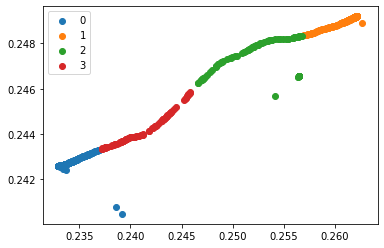

In [128]:
u_labels = np.unique(label)
#plotting the results:
for i in u_labels:
    plt.scatter(Training_Feature_vector[label == i, 0], Training_Feature_vector[label == i, 1], label = i)
plt.legend()
plt.show()